In [2]:
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible
import glob
from aicspylibczi import CziFile

2022-09-04 13:28:27.873224: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
model_name = 'n2v_3D_6channel'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

2022-09-04 13:28:33.703998: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-04 13:28:33.718560: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-04 13:28:33.816574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 13:28:33.818174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-09-04 13:28:33.818196: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-04 13:28:33.925623: I tensorflow/stream_executor/platform/default/dso_loade

Loading network weights from 'weights_best.h5'.


In [4]:
path = glob.glob('/mnt/shared/potatoshapes/shannonsdata/raw_data/3D_data/*.czi')


In [5]:
len(path)

124

In [6]:
img, shape = CziFile(path[1]).read_image() # image of index 1 has a problem (maybe not uploaded yet or maybe corrupt from bad upload)
print(img.shape)
img = np.squeeze(img)
print(img.shape)
if img.shape[0] == 7:
    img = img[:-1,...]
print(img.shape)
img = np.moveaxis(img, [0], [3])
print(img.shape)
img_SZYXC = np.expand_dims(img, axis=0)
print(img_SZYXC.shape)




(1, 1, 1, 6, 33, 1688, 1688)
(6, 33, 1688, 1688)
(6, 33, 1688, 1688)
(33, 1688, 1688, 6)
(1, 33, 1688, 1688, 6)


In [13]:
img_lys = img_SZYXC[0,:,744:944,744:944,:]
print(img_lys.shape)

(33, 200, 200, 6)


In [15]:
pred = model.predict(img_lys, axes='ZYXC')


The input image is of type uint16 and will be casted to float32 for prediction.


2022-09-04 13:33:26.828807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-04 13:33:26.858977: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz
2022-09-04 13:33:28.338651: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-09-04 13:33:31.094602: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-09-04 13:33:31.183549: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-04 13:33:31.757417: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [16]:
pred.shape

(33, 200, 200, 6)

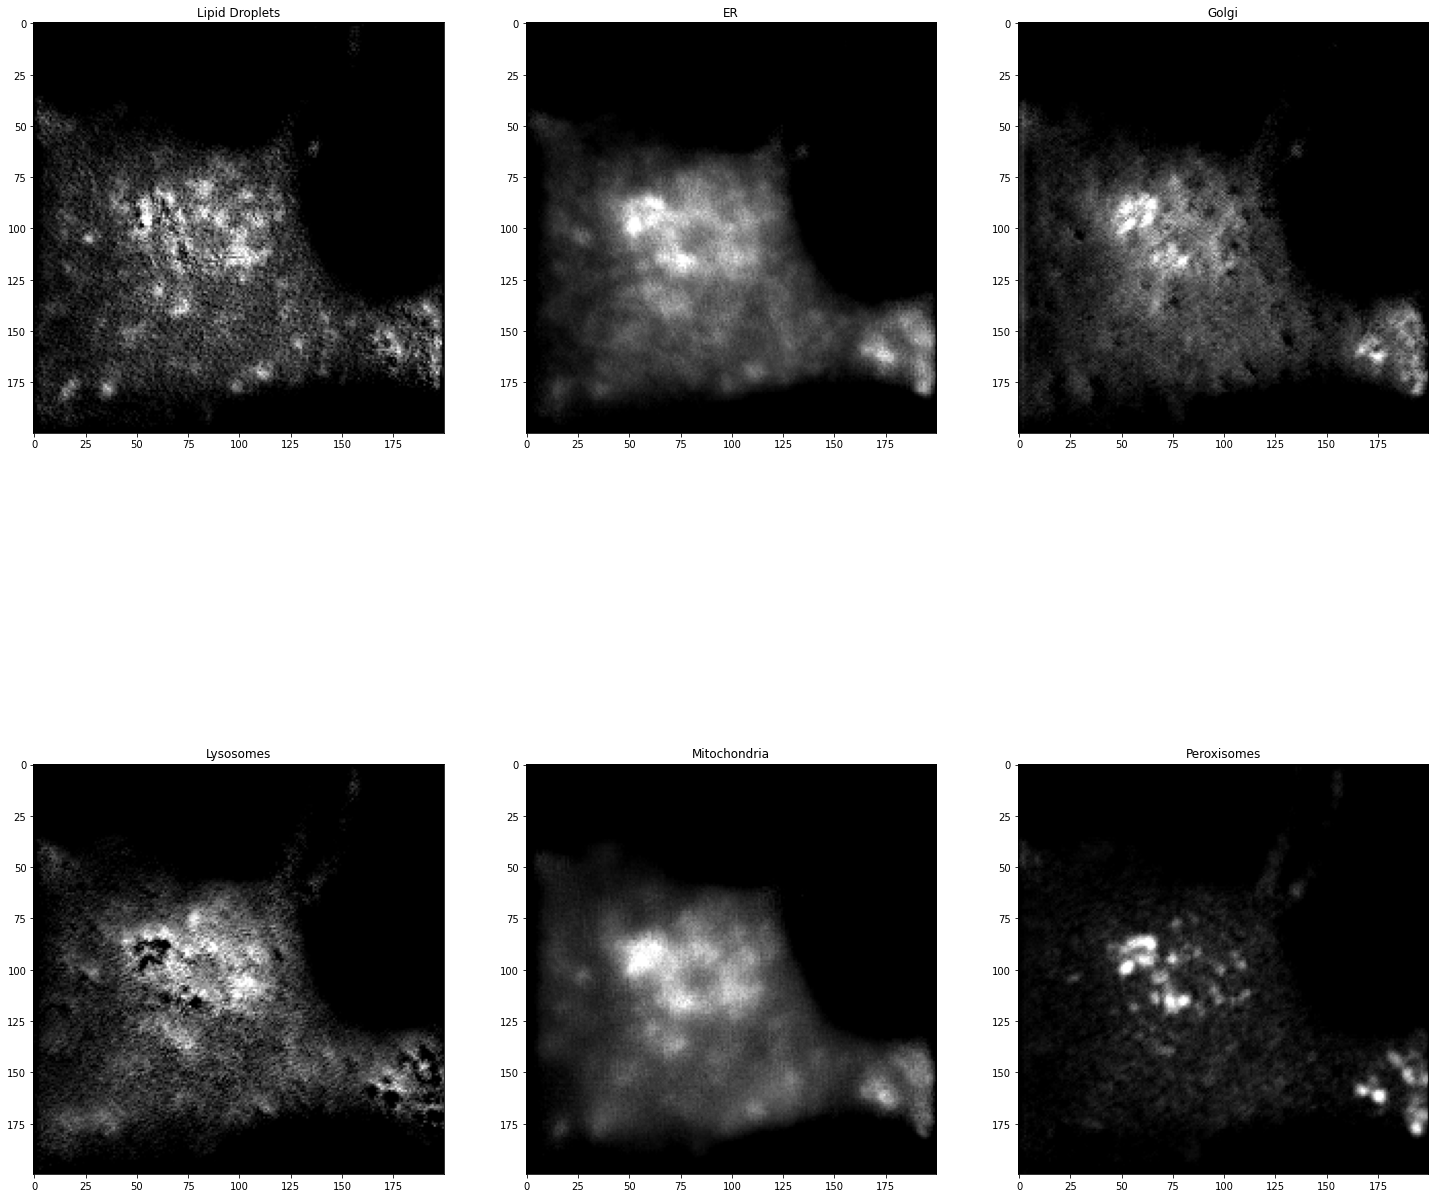

In [17]:
def norm_by(x, min_, max_):
    norms = np.percentile(x, [min_, max_])
    i2 = np.clip((x - norms[0])/(norms[1]-norms[0]), 0, 1)
    return i2

c0 = (norm_by(pred[5, :, :, 0], 50, 99.8)*255).astype(np.uint8)
c1 = (norm_by(pred[5, :, :, 1], 50, 99.8)*255).astype(np.uint8)
c2 = (norm_by(pred[5, :, :, 2], 50, 99.8)*255).astype(np.uint8)
c3 = (norm_by(pred[5, :, :, 3], 50, 99.8)*255).astype(np.uint8)
c4 = (norm_by(pred[5, :, :, 4], 50, 99.8)*255).astype(np.uint8)
c5 = (norm_by(pred[5, :, :, 5], 50, 99.8)*255).astype(np.uint8)
plt.figure(figsize=(25,25))
plt.subplot(2,3,1)
plt.imshow(c0, cmap='gray')
plt.title('Lipid Droplets');
plt.subplot(2,3,2)
plt.imshow(c1, cmap='gray')
plt.title('ER');
plt.subplot(2,3,3)
plt.imshow(c2, cmap='gray')
plt.title('Golgi');
plt.subplot(2,3,4)
plt.imshow(c3, cmap='gray')
plt.title('Lysosomes');
plt.subplot(2,3,5)
plt.imshow(c4, cmap='gray')
plt.title('Mitochondria');
plt.subplot(2,3,6)
plt.imshow(c5, cmap='gray')
plt.title('Peroxisomes')
plt.show()